## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [9]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping

#earlystop = EarlyStopping(monitor="val_loss", 
#                          patience=5, 
#                          verbose=1
#                          )

results = {}

patiencelist = [10, 25]

"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for pat in patiencelist:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    earlystop = EarlyStopping(monitor="val_accuracy", 
                              patience=pat, 
                              verbose=1
                              )
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    exp_name_tag = "patience: %.0f" %(pat)
    results[exp_name_tag] = {'train-loss': train_loss,
                            'valid-loss': valid_loss,
                            'train-acc': train_acc,
                            'valid-acc': valid_acc}

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512   

49/49 [==============================] - 2s 51ms/step - loss: 1.7417 - accuracy: 0.3950 - val_loss: 1.9664 - val_accuracy: 0.3143
Epoch 3/50
49/49 [==============================] - 2s 51ms/step - loss: 1.6161 - accuracy: 0.4367 - val_loss: 1.8085 - val_accuracy: 0.3834
Epoch 4/50
49/49 [==============================] - 2s 50ms/step - loss: 1.5411 - accuracy: 0.4606 - val_loss: 1.7084 - val_accuracy: 0.4058
Epoch 5/50
49/49 [==============================] - 3s 52ms/step - loss: 1.4855 - accuracy: 0.4800 - val_loss: 1.6258 - val_accuracy: 0.4299
Epoch 6/50
49/49 [==============================] - 3s 56ms/step - loss: 1.4384 - accuracy: 0.4988 - val_loss: 1.5797 - val_accuracy: 0.4453
Epoch 7/50
49/49 [==============================] - 3s 53ms/step - loss: 1.3987 - accuracy: 0.5118 - val_loss: 1.5469 - val_accuracy: 0.4506
Epoch 8/50
49/49 [==============================] - 2s 50ms/step - loss: 1.3616 - accuracy: 0.5273 - val_loss: 1.5083 - val_accuracy: 0.4674
Epoch 9/50
49/49 [======

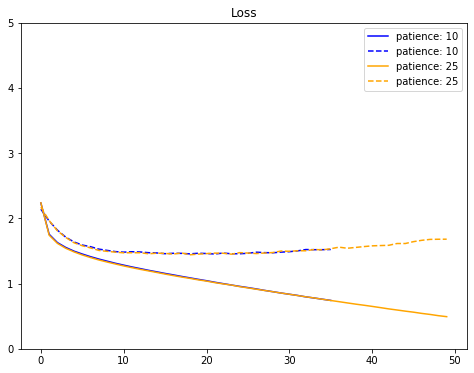

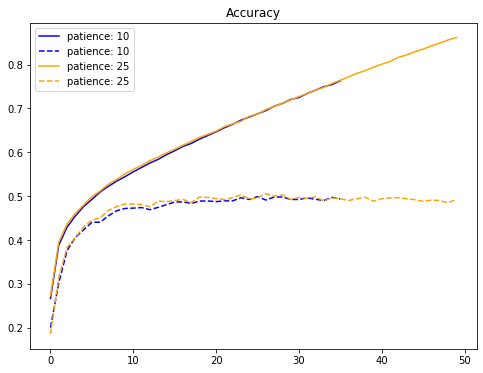

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["Blue", "Orange", "Green", "Red", "Purple", "Brown" ,"pink" , "gray"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()